# Проект Data Science для золотодобывающей отрасли

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.\
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки.\
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.\
Нам нужно:
- подготовить данные;
- провести исследовательский анализ данных;
- построить и обучить модель.

Описание данных

**Технологический процесс**\
*Rougher feed* — исходное сырье\
*Rougher additions (или reagent additions)* — флотационные реагенты: Xanthate, Sulphate, Depressant\
  
Xanthate — ксантогенат (промотер, или активатор флотации);\
Sulphate — сульфат (на данном производстве сульфид натрия);\
Depressant — депрессант (силикат натрия).\
Rougher process (англ. «грубый процесс») — флотация\
Rougher tails — отвальные хвосты\
Float banks — флотационная установка\
Cleaner process — очистка\
Rougher Au — черновой концентрат золота\
Final Au — финальный концентрат золота\

**Параметры этапов**\
air amount — объём воздуха\
fluid levels — уровень жидкости\
feed size — размер гранул сырья\
feed rate — скорость подачи

**Расчёт эффективности**\
Нам нужно смоделировать процесс восстановления золота из золотосодержащей руды. 

Эффективность обогащения рассчитывается по формуле\
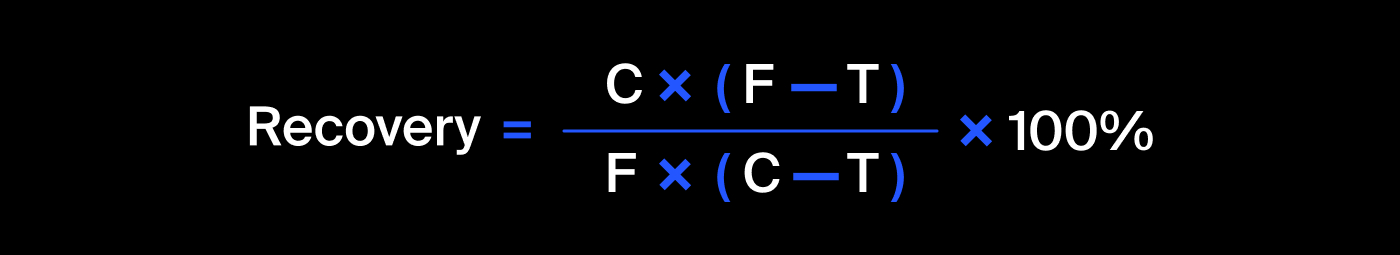
где:\
C — доля золота в концентрате после флотации/очистки;\
F — доля золота в сырье/концентрате до флотации/очистки;\
T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.feature_selection import mutual_info_regression 
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

## Подготовка данных 

###  Откроем файлы и изучим их.

In [2]:
try:
    df_full = pd.read_csv('gold_recovery_full_new.csv')
    df_test = pd.read_csv('gold_recovery_test_new.csv')
    df_train = pd.read_csv('gold_recovery_train_new.csv')
except:
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')

In [3]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [6]:
pd.set_option('display.max_columns', None)
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

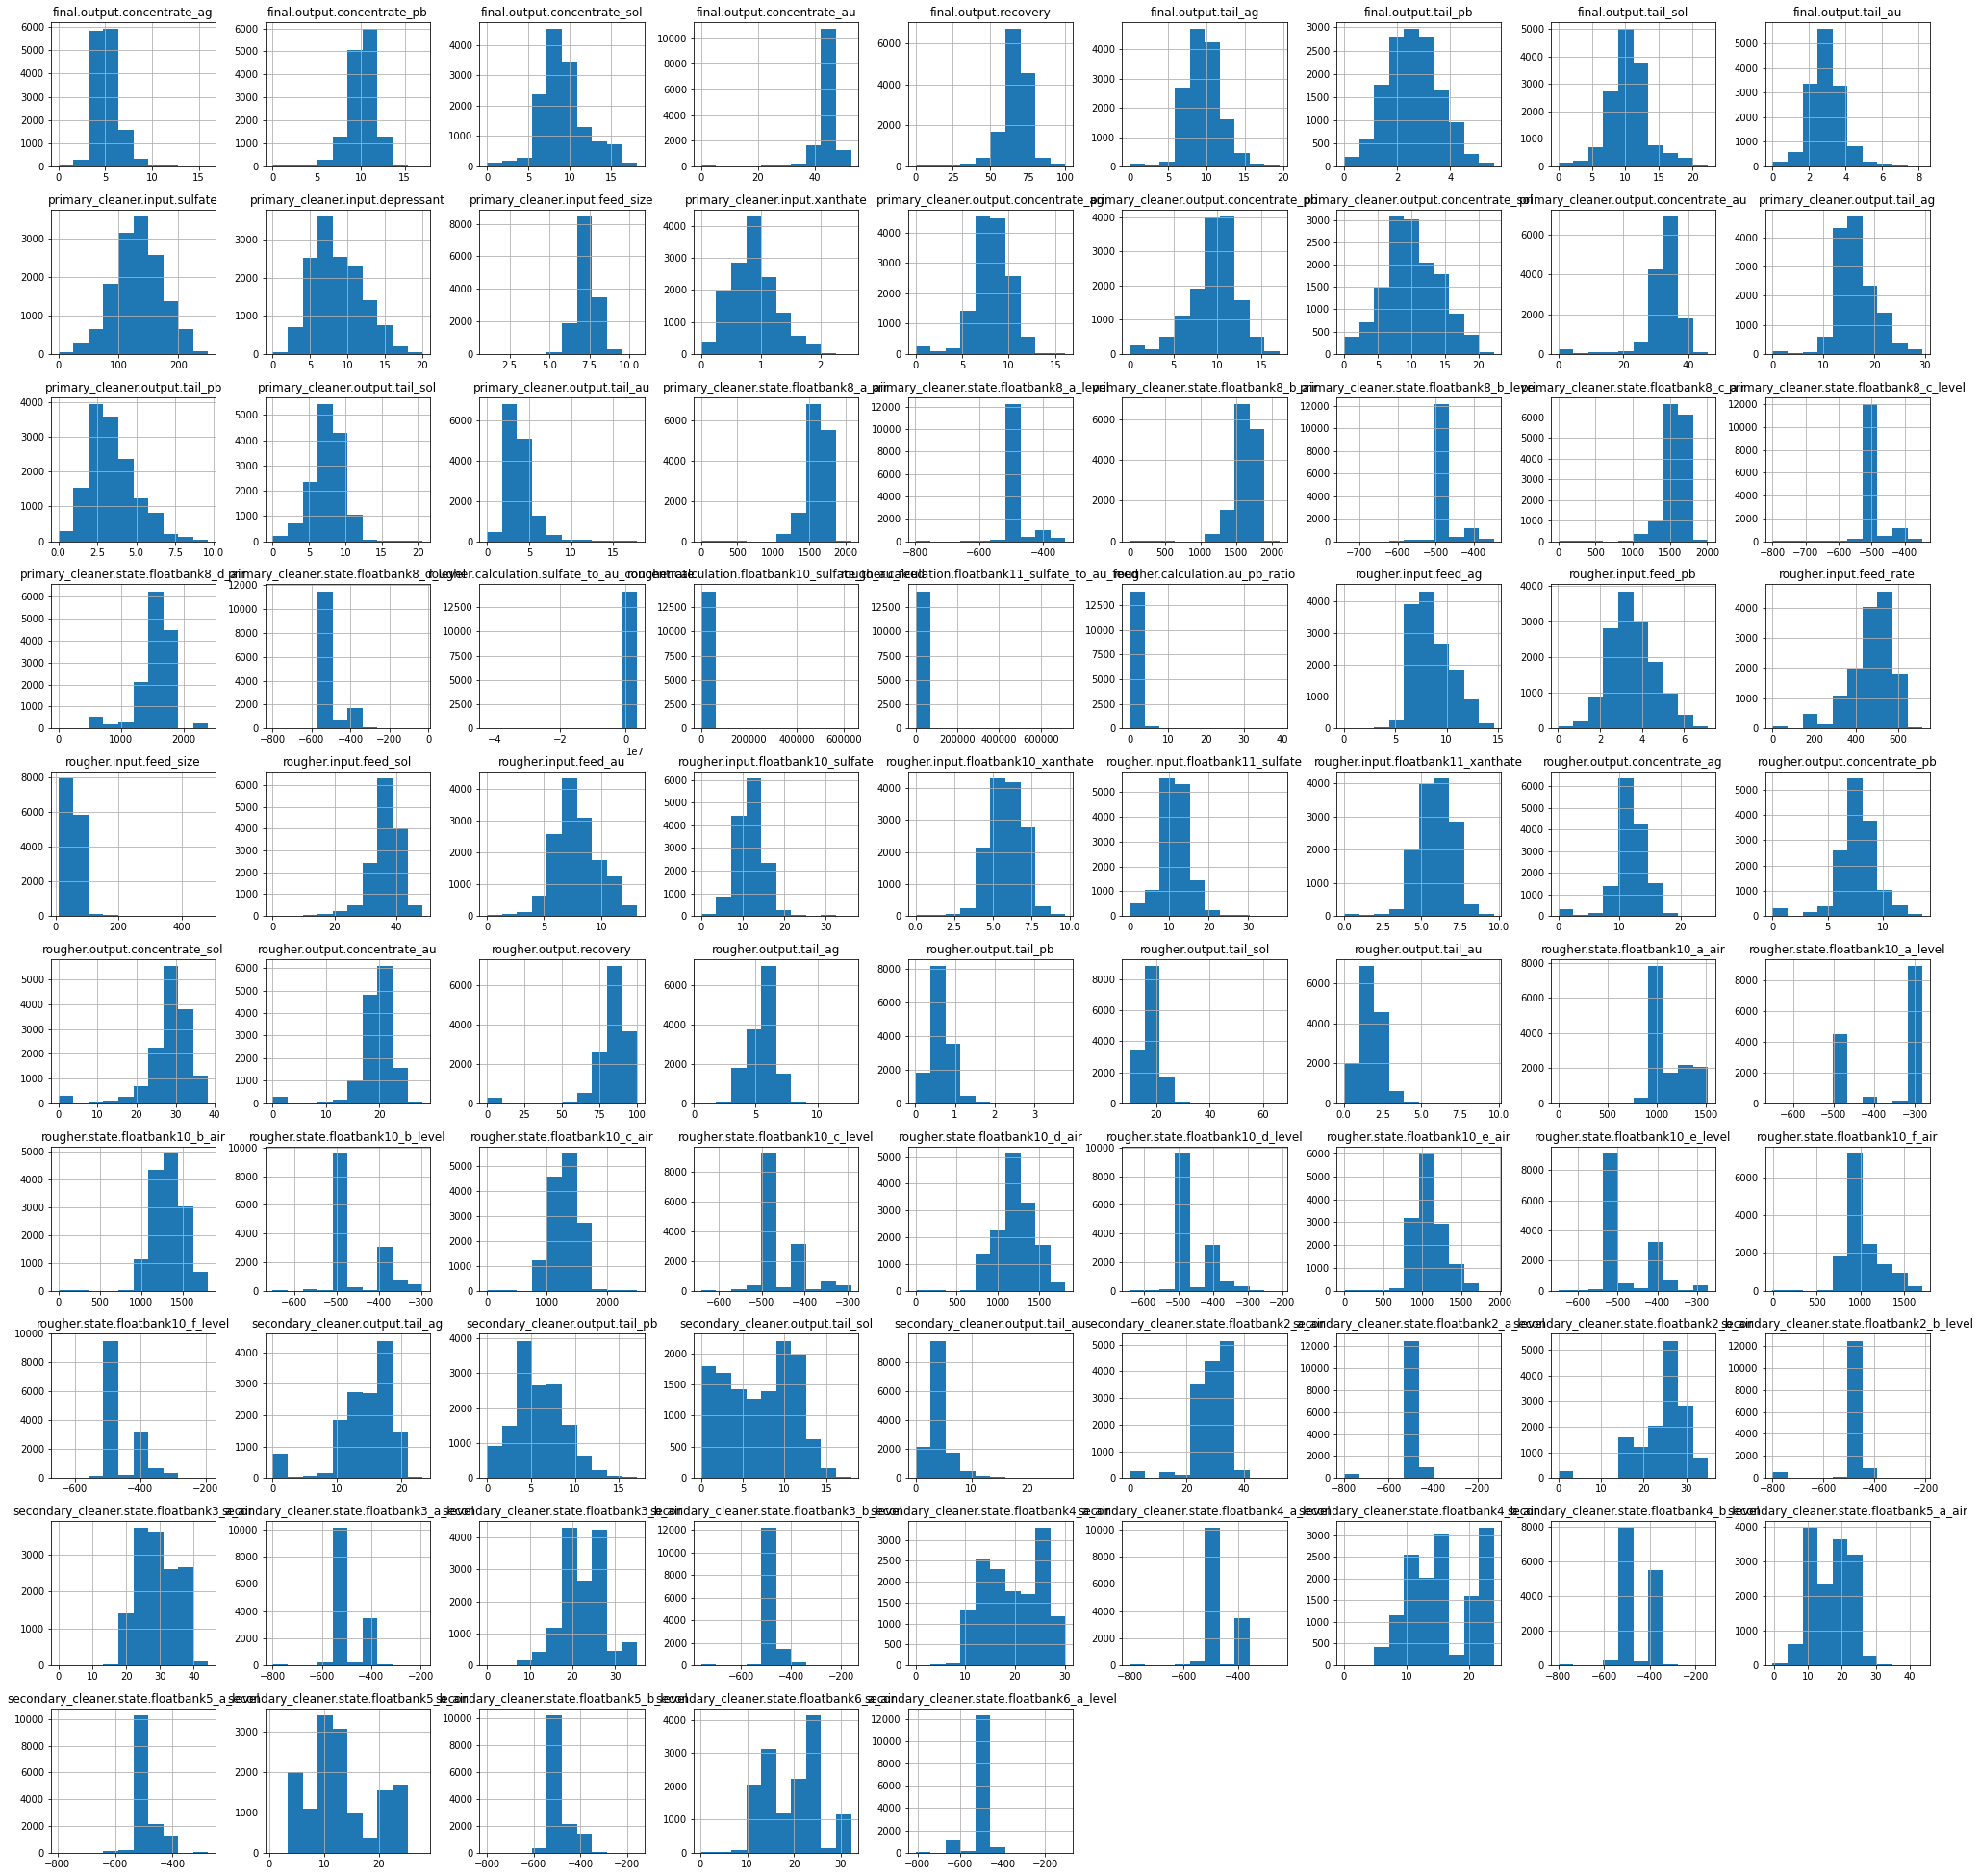

In [7]:
df_train.hist(figsize=(35,35));

###  Проверим, что эффективность обогащения рассчитана правильно.

In [8]:
def recovery(c,f,t): # функция расчета эффективности обогащения золотосодержащей руды
    recovery = c*(f-t)*100/(f*(c-t))
    return(recovery)

In [9]:
recovery_au = recovery(
    df_train['rougher.output.concentrate_au'],df_train['rougher.input.feed_au'],df_train['rougher.output.tail_au']
)
recovery_au

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64

In [10]:
mae = mean_absolute_error(df_train['rougher.output.recovery'], recovery_au) # расчет MAE 
mae

1.1131451184435918e-14

Среднее абсолютное отклонение(MAE) наших расчетов и расчетов в исходных данных практически равно нулю. Значит, эффективность обогащения в исходных данных рассчитана верно.

### Анализ признаков, предобработка данных

В тестовой выборке находятся только те признаки, которые известны до начала процесса (флотации/очистки). Остальные признаки являются выходными параметрами, которые нельзя рассчитать заранее. \
Соответственно, обучать модель также необходимо только на признаках до начала процессов(чтобы избежать утечки данных).

In [11]:
df_train = df_train.drop(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au','primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au',
       'rougher.output.tail_ag', 'rougher.output.tail_pb',
       'rougher.output.tail_sol', 'rougher.output.tail_au','secondary_cleaner.output.tail_ag', 
       'secondary_cleaner.output.tail_pb',
       'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au'],axis=1)

Для оценки предсказаний модели необходимо добавить в тестовую выборку целевые признаки "rougher.output.recovery", "final.output.recovery".

In [12]:
df_test = df_test.merge(df_full[['final.output.recovery', 'rougher.output.recovery', 'date']], how='left', on='date')

In [13]:
df_test.shape

(5290, 55)

In [14]:
df_test = df_test.dropna() # удалим пропуски в тестовой выборке

В условии к проекту сказано, что соседние по времени параметры часто похожи, а данные отсортированы по дате и времени, поэтому попробуем заполнить пропуски предыдущими значениями с помощью метода ffill:

In [15]:
df_train = df_train.fillna(method='ffill')

In [16]:
df_train.isna().sum()

date                                          0
final.output.recovery                         0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate       

## Анализ данных

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [17]:
def concentration(list_conc,names): # функция построения гистограмм распределения металлов по этапам очистки 
    plt.figure(figsize=(13,7))
    for item in list_conc:
        item.hist(bins=25, label=item.name, alpha=0.5)

    plt.title(f'Диаграмма концентрации {names} на различных этапах очистки')

    plt.legend(loc='upper left')
    plt.xlabel(f'Доля {names} в концентратах на различных этапах очистки, %')
    plt.ylabel('Количество')
    plt.show()

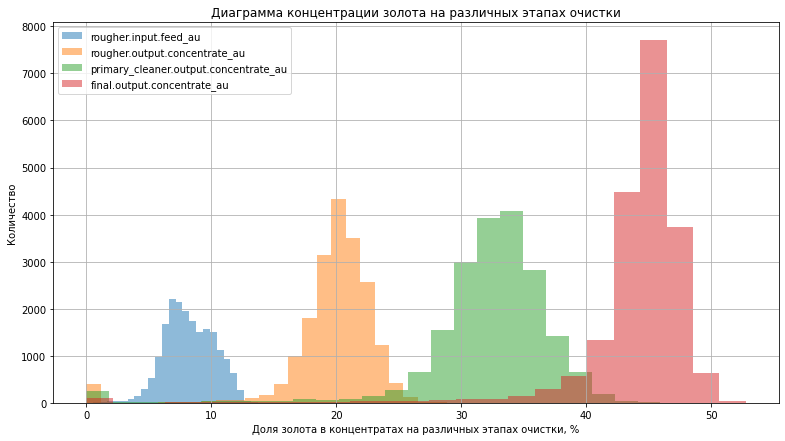

In [18]:
concentration([
    df_full['rougher.input.feed_au'],
    df_full['rougher.output.concentrate_au'], 
    df_full['primary_cleaner.output.concentrate_au'], 
    df_full['final.output.concentrate_au']
],'золота')

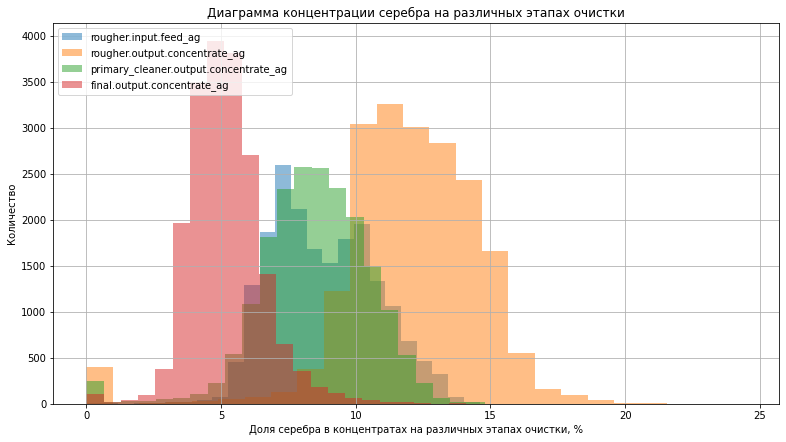

In [19]:
concentration([
    df_full['rougher.input.feed_ag'],
    df_full['rougher.output.concentrate_ag'], 
    df_full['primary_cleaner.output.concentrate_ag'], 
    df_full['final.output.concentrate_ag']
],'серебра')

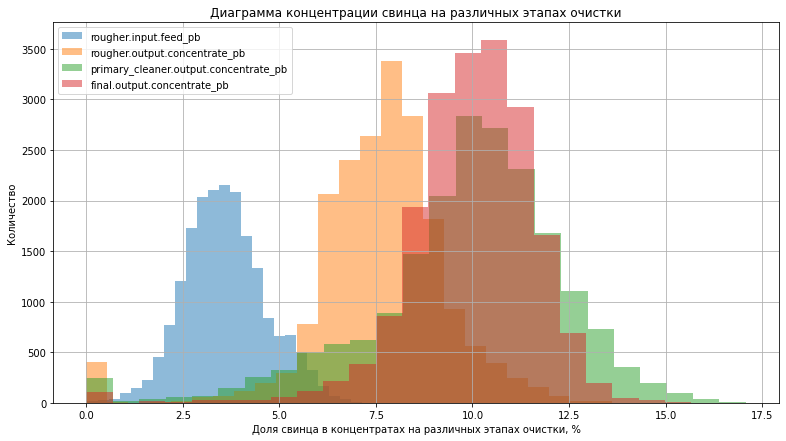

In [20]:
concentration([
    df_full['rougher.input.feed_pb'],
    df_full['rougher.output.concentrate_pb'], 
    df_full['primary_cleaner.output.concentrate_pb'], 
    df_full['final.output.concentrate_pb']
],'свинца')

In [21]:
def plot_pie(data1, data2, data3, data4, name): # функция построения круговых диаграмм распределения металлов
    fig = plt.figure(figsize =(20, 5))
    fig.suptitle('Обзор содержания металлов в концентрате до и после очистки',fontsize=20)
    
    plt.subplot(1, 4, 1)
    plt.pie(data1, labels=name)
 
    plt.title('Доли металлов до флотации')

    plt.subplot(1, 4, 2)
    plt.pie(data2, labels=name)
    plt.title('Доли металлов после флотации')
    
    plt.subplot(1, 4, 3)
    plt.pie(data3, labels=name)
    plt.title('Доли металлов после первичной очистки')
    
    plt.subplot(1, 4, 4)
    plt.pie(data4, labels=name)
    plt.title('Доли металлов в финальном концентрате')
    plt.show()

In [22]:
data1 = [
    df_full['rougher.input.feed_au'].mean(),
    df_full['rougher.input.feed_ag'].mean(),
    df_full['rougher.input.feed_pb'].mean(),
    df_full['rougher.input.feed_sol'].mean(), 
   ]

data2 = [
    df_full['rougher.output.concentrate_au'].mean(),
    df_full['rougher.output.concentrate_ag'].mean(),
    df_full['rougher.output.concentrate_pb'].mean(),
    df_full['rougher.output.concentrate_sol'].mean(), 
   ]

data3 = [
    df_full['primary_cleaner.output.concentrate_au'].mean(),
    df_full['primary_cleaner.output.concentrate_ag'].mean(),
    df_full['primary_cleaner.output.concentrate_pb'].mean(),
    df_full['primary_cleaner.output.concentrate_sol'].mean(), 
    ]

data4 = [
    df_full['final.output.concentrate_au'].mean(),
    df_full['final.output.concentrate_ag'].mean(),
    df_full['final.output.concentrate_pb'].mean(),
    df_full['final.output.concentrate_sol'].mean(),
    ] 
name = ['au','ag','pb','sol']

In [23]:
def plot_pie_tail(data1, data2, data3, name): # круговые диаграммы содержания металлов в отвальных хвостах
    fig = plt.figure(figsize =(20,7))
    fig.suptitle('Обзор содержания металлов в "хвостах" после флотации и очисток',fontsize=20)
    
    plt.subplot(1, 3, 1)
    plt.pie(data1, labels=name)
 
    plt.title('Доли металлов в "хвостах" после флотации')

    plt.subplot(1, 3, 2)
    plt.pie(data2, labels=name)
    plt.title('Доли металлов в "хвостах" после первичной очистки')
    
    plt.subplot(1, 3, 3)
    plt.pie(data3, labels=name)
    plt.title('Доли металлов в "хвостах" после вторичной очистки')
    
   
    plt.show()

In [24]:
data_tail1 = [
    df_full['rougher.output.tail_au'].mean(),
    df_full['rougher.output.tail_ag'].mean(),
    df_full['rougher.output.tail_pb'].mean(),
    df_full['rougher.output.tail_sol'].mean() 
   ]

data_tail2 = [
    df_full['primary_cleaner.output.tail_au'].mean(),
    df_full['primary_cleaner.output.tail_ag'].mean(),
    df_full['primary_cleaner.output.tail_pb'].mean(),
    df_full['primary_cleaner.output.tail_sol'].mean() 
    ]

data_tail3 = [
    df_full['final.output.tail_au'].mean(),
    df_full['final.output.tail_ag'].mean(),
    df_full['final.output.tail_pb'].mean(),
    df_full['final.output.tail_sol'].mean()
    ] 
name = ['au','ag','pb','sol']

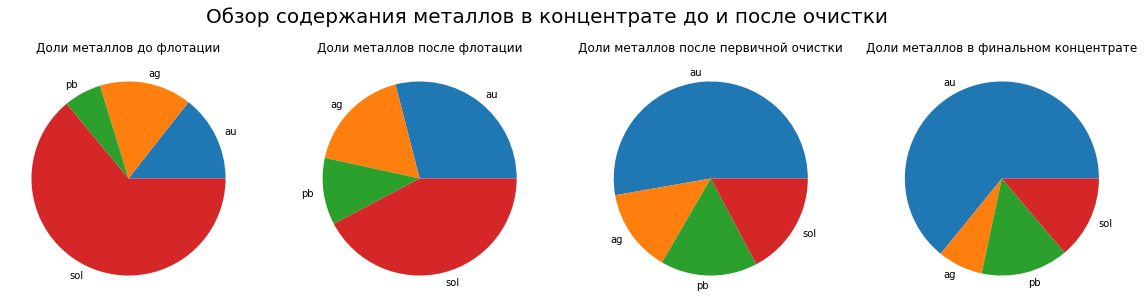

In [25]:
plot_pie(data1, data2, data3, data4, name)

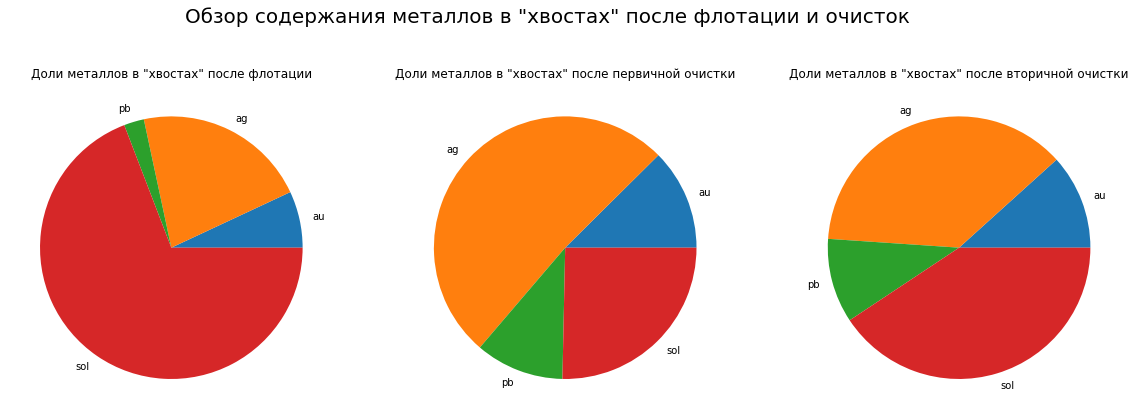

In [26]:
plot_pie_tail(data_tail1, data_tail2, data_tail3, name)

**Вывод.** Из приведенных выше графиков и диаграмм следует: 
- доля золота в концентрате увеличивается с каждым этапом флотации и очистки; в финальном концентрате золото преобладает среди остальных металлов; концентрация золота в отвальных хвостах нзначительно увеличивается;
- доля серебра в концентрате незначительно увеличивается после флотации, затем снижается после каждого этапа очистки; в отвальных хвостах концентрация серебра становится выше после этапов очистки(самая высокая- после первичной очистки);
- доля свинца в концентрате увеличивается с каждым этапом флотации и очистки(но его концентрация в несколько раз ниже концентрации золота); доля свинца в отвальных хвостах увеличивается с каждым этапом очистки.  

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

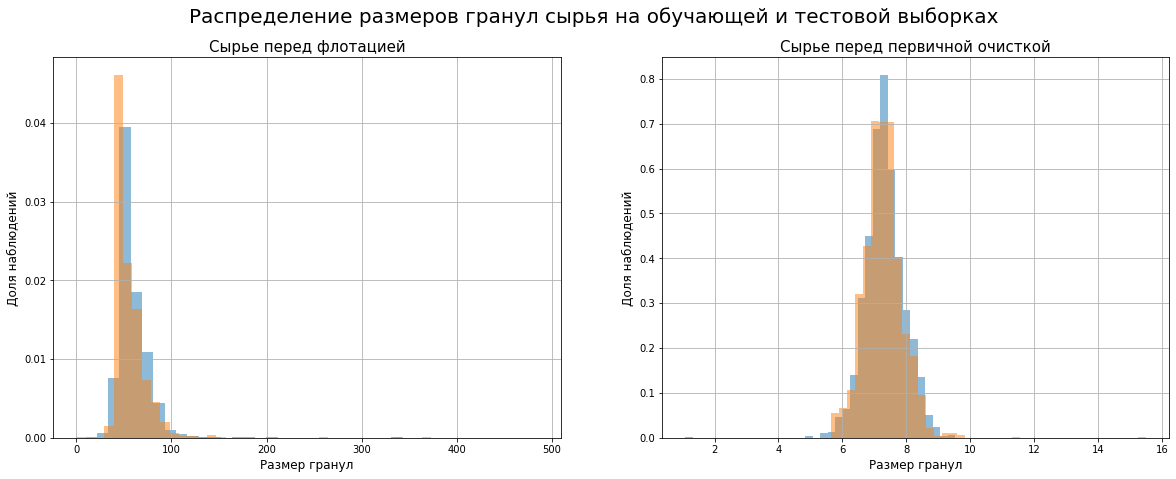

In [27]:
fig = plt.figure(figsize =(20, 7))
fig.suptitle('Распределение размеров гранул сырья на обучающей и тестовой выборках',fontsize=20)
  
    
plt.subplot(1, 2, 1)
df_train['rougher.input.feed_size'].hist(density=True, bins=40, alpha=0.5)
df_test['rougher.input.feed_size'].hist(density=True, bins=40, alpha=0.5)
plt.xlabel('Размер гранул', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12) 
plt.title('Сырье перед флотацией', fontsize=15)

plt.subplot(1, 2, 2)
df_train['primary_cleaner.input.feed_size'].hist(density=True, bins=40, alpha=0.5)
df_test['primary_cleaner.input.feed_size'].hist(density=True, bins=40, alpha=0.5)

plt.title('Сырье перед первичной очисткой', fontsize=15)
plt.xlabel('Размер гранул', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)    
    
plt.show()

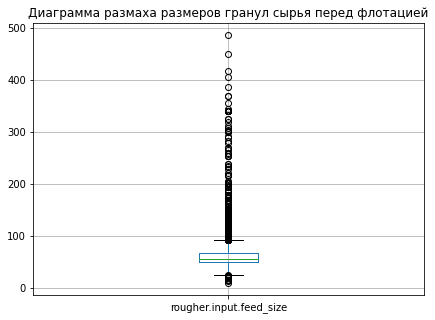

In [28]:
fig = plt.figure(figsize =(7, 5))
df_train[['rougher.input.feed_size']].boxplot()
plt.title('Диаграмма размаха размеров гранул сырья перед флотацией');

In [29]:
df_train[['rougher.input.feed_size']].describe()

,rougher.input.feed_size
count,14149.000000
mean,60.239856
std,23.005310
min,9.659576
25%,48.966751
50%,55.269784
75%,66.007526
max,484.967466


In [30]:
df_train = df_train[df_train['rougher.input.feed_size']<200] # оставим только данные с размером гранул меньше 200

In [31]:
df_train.shape # проверим размер получившейся выборки

(14075, 55)

- Из графиков следует, что распределения размеров гранул сырья для тренировочной и тестовой выборок схожи.
- В распределении размера гранул для исходного сырья видны выбросы: значения размеров доходят до 500. Мы удалили все строки с значениями размеров гранул свыше 200.

###  Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [32]:
df_full['sum_rinput'] = df_full['rougher.input.feed_au']+\
                     df_full['rougher.input.feed_ag']+\
                     df_full['rougher.input.feed_pb']+\
                     df_full['rougher.input.feed_sol']

df_full['sum_routput'] = df_full['rougher.output.concentrate_au']+\
                      df_full['rougher.output.concentrate_ag']+\
                      df_full['rougher.output.concentrate_pb']+\
                      df_full['rougher.output.concentrate_sol']

df_full['sum_final'] = df_full['final.output.concentrate_au']+\
                      df_full['final.output.concentrate_ag']+\
                      df_full['final.output.concentrate_pb']+\
                      df_full['final.output.concentrate_sol']

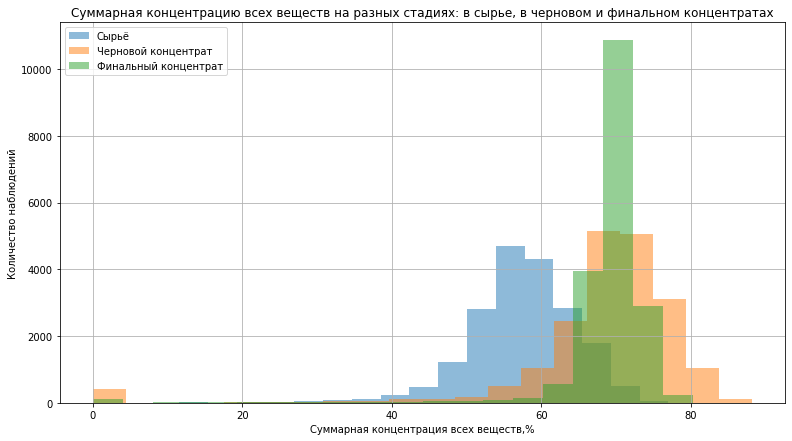

In [33]:
plt.figure(figsize=(13,7))
df_full['sum_rinput'].hist(bins=20, label='Сырьё', alpha=0.5)
df_full['sum_routput'].hist(bins=20, label='Черновой концентрат', alpha=0.5)
df_full['sum_final'].hist(bins=20, label='Финальный концентрат', alpha=0.5);

plt.title('Суммарная концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах')

plt.legend(loc='upper left')
plt.xlabel('Суммарная концентрация всех веществ,%')
plt.ylabel('Количество наблюдений')
plt.show()


С каждым этапом очистки концентрация металлов в концентратах увеличивается, особенно резкое увеличение концентрации и сужение диапазона распределения заметно в финальном концентрате, после второй очистки.\
На графике видны выбросы в районе нулевых значений концентраций, проверим и удалим их.

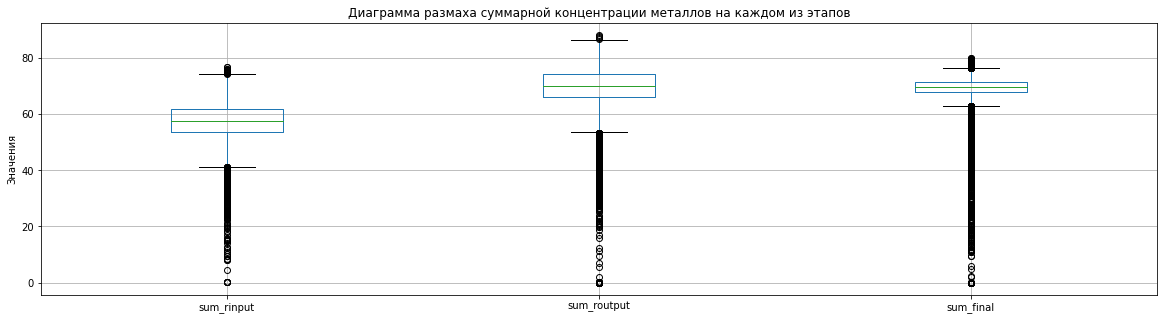

In [34]:
df_full[['sum_rinput', 'sum_routput', 'sum_final']].boxplot(figsize = (20,5))
plt.title('Диаграмма размаха суммарной концентрации металлов на каждом из этапов')
plt.ylabel('Значения')
plt.show()

In [35]:
df_full[['sum_rinput', 'sum_routput', 'sum_final']].describe()

,sum_rinput,sum_routput,sum_final
count,19245.000000,19416.000000,19227.000000
mean,57.407926,68.188914,68.727562
std,7.165219,12.478522,7.423741
min,0.040000,0.000000,0.000000
25%,53.660745,66.026048,67.985659
50%,57.647093,70.186130,69.632597
75%,62.012223,74.362878,71.390461
max,76.978947,88.140119,80.210644


In [36]:
df_full.shape

(19439, 90)

In [37]:
df_full = df_full.query('sum_rinput>30 & sum_routput>30 & sum_final>30')
df_full.shape

(18377, 90)

In [38]:
df_train['sum_rinput'] = df_train['rougher.input.feed_au']+\
                     df_train['rougher.input.feed_ag']+\
                     df_train['rougher.input.feed_pb']+\
                     df_train['rougher.input.feed_sol']

df_train = df_train.query('sum_rinput>30')
df_train.shape

(14003, 56)

**Вывод**
- Доля золота в сырье и концентратах увеличивается с каждым этапом очистки.
- Распределение размеров гранул в тренировочной и тестовой выборках схожи.
- Выявлены и удалены строки с нулевыми значениями суммарной концентрации всех металлов после флотации и в финальном концентрате.

### Подготовка признаков к обучению модели

#### Отбор признаков

Выделим в выборках целевые признаки:

In [39]:
# в тренировочной выборке для флотации удалим все признаки с данными, полученными после флотации, а также целевые признаки 
features_train_rougher = df_train.drop([
       'date','rougher.output.recovery','final.output.recovery','sum_rinput',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level'], axis=1)

target_train_rougher = df_train['rougher.output.recovery'] # целевой признак для тренировочной выборки с флотацией

# в тренировочной выборке  для финальной очистки удалим целевые признаки, дату и столбец 'sum_rinput'
features_train_final = df_train.drop(['date','rougher.output.recovery','final.output.recovery','sum_rinput'], axis=1)
target_train_final = df_train['final.output.recovery'] # целевой признак для тренировочной выборки финальной очистки 

# в тестовой выборке для флотации удалим все признаки с данными, полученными после флотации, а также целевые признаки 
features_test_rougher = df_test.drop([
       'date','rougher.output.recovery','final.output.recovery',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level'], axis=1)

target_test_rougher = df_test['rougher.output.recovery'] # целевой признак для тестовой выборки с флотацией

# в тестовойй выборке  для финальной очистки удалим целевые признаки и дату
features_test_final = df_test.drop(['date','rougher.output.recovery','final.output.recovery'], axis=1)
target_test_final = df_test['final.output.recovery'] # целевой признак для тестовой выборки финальной очистки 

CPU times: user 581 ms, sys: 82.3 ms, total: 663 ms
Wall time: 681 ms


<AxesSubplot:>

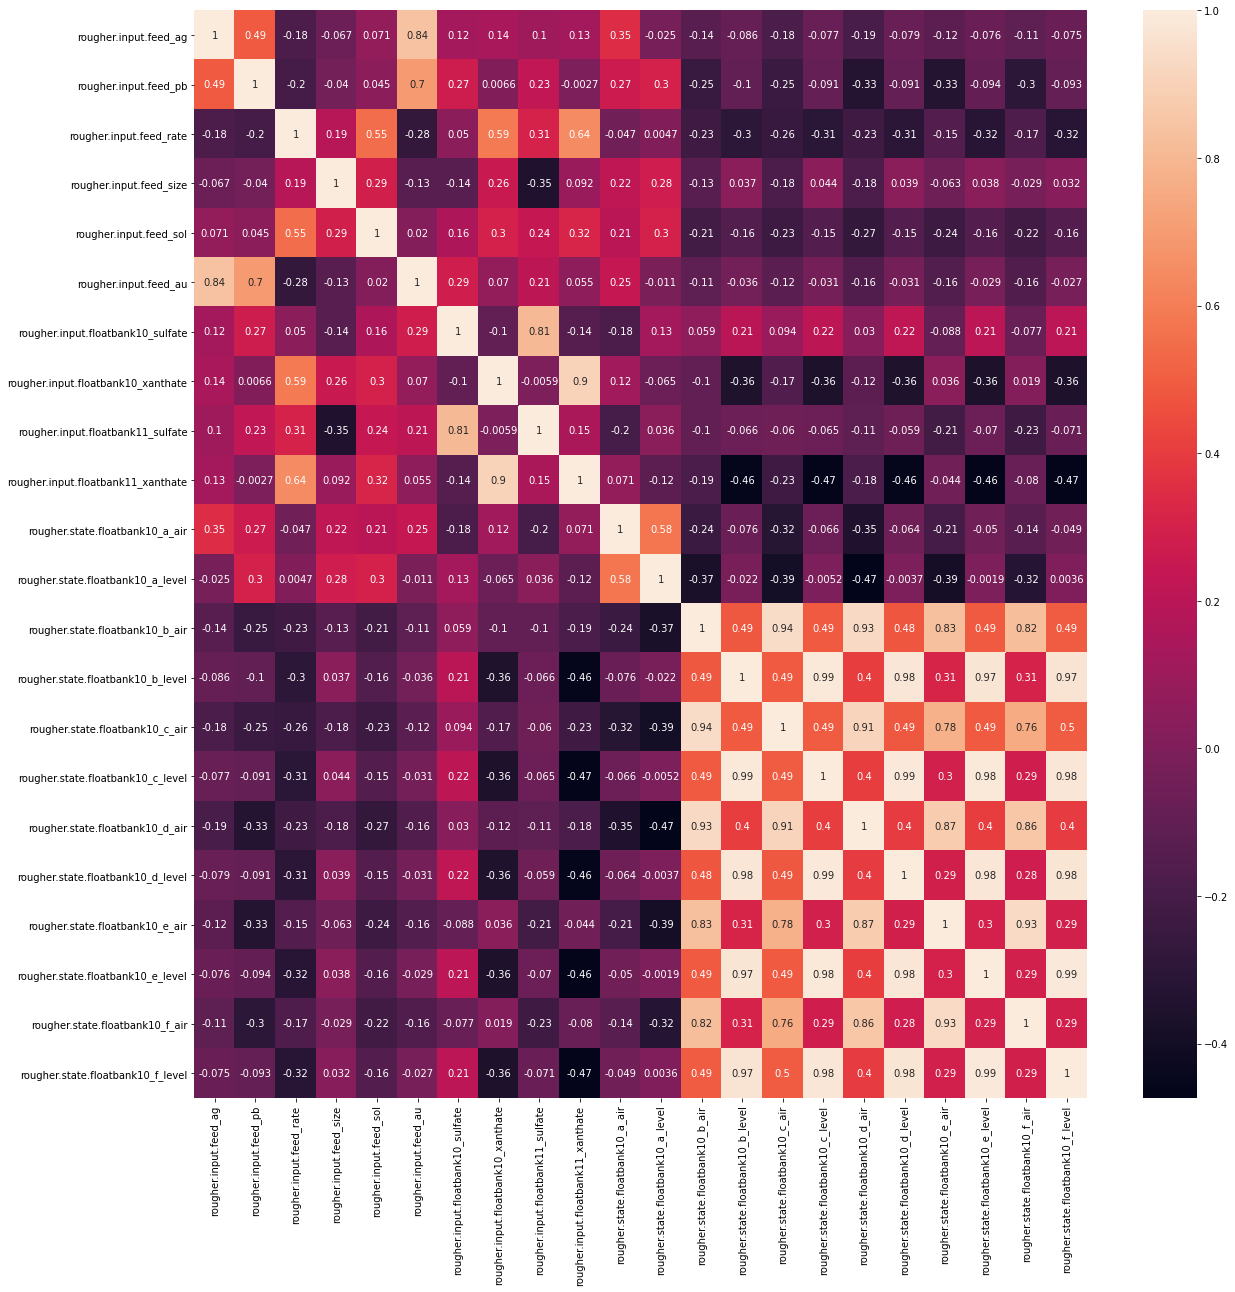

In [40]:
%%time
coor_matrix = features_train_rougher.corr()  # посмотрим на матрицу корреляции признаков выборки для флотации 
plt.figure(figsize=(20,20))
sns.heatmap(coor_matrix, annot=True);

In [41]:
# для применения линейной модели в тренировочной выборке флотации удалим признаки с корреляцией выше 0.8
features_train_linear_rougher = features_train_rougher.drop([
        'rougher.state.floatbank10_c_level',
        'rougher.state.floatbank10_d_level',
        'rougher.state.floatbank10_e_level',
        'rougher.state.floatbank10_f_level',
        'rougher.input.floatbank11_sulfate',
        'rougher.input.floatbank11_xanthate',
        'rougher.input.feed_ag', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_e_air'], axis=1)

# для применения линейной модели в тестовой выборке  удалим те же признаки 
features_test_linear_rougher = features_test_rougher.drop([
        'rougher.state.floatbank10_c_level',
        'rougher.state.floatbank10_d_level',
        'rougher.state.floatbank10_e_level',
        'rougher.state.floatbank10_f_level',
        'rougher.input.floatbank11_sulfate',
        'rougher.input.floatbank11_xanthate',
        'rougher.input.feed_ag', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_e_air'], axis=1)

CPU times: user 232 ms, sys: 78.9 ms, total: 311 ms
Wall time: 319 ms


<AxesSubplot:>

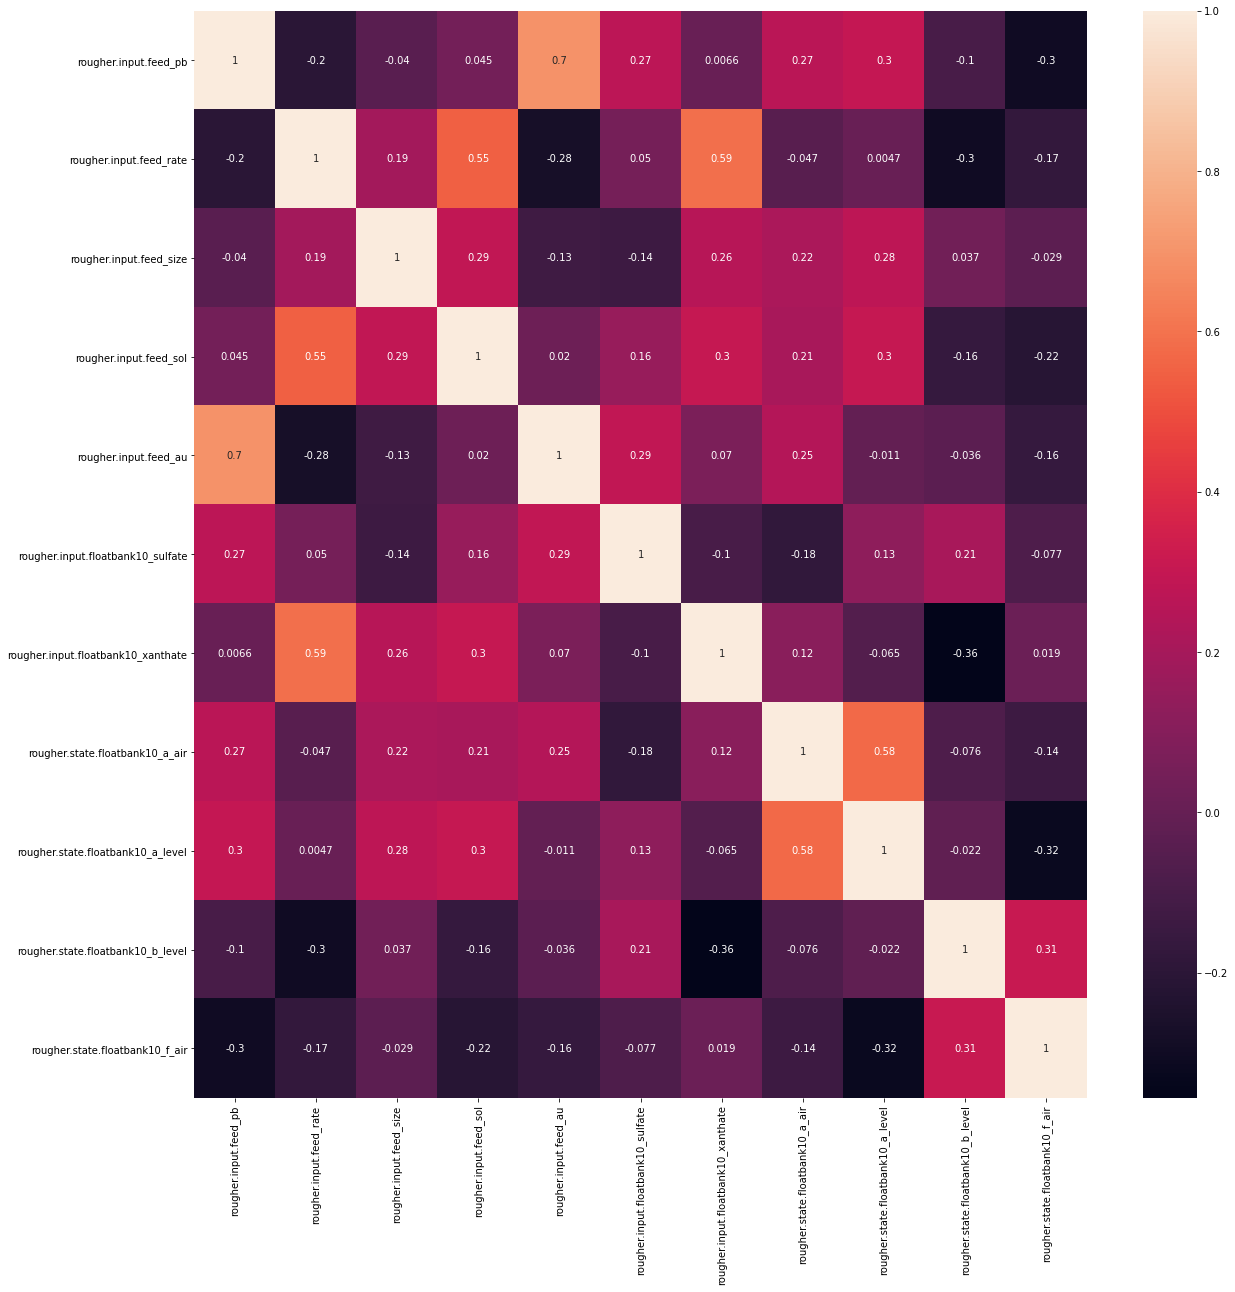

In [42]:
%%time
coor_matrix = features_train_linear_rougher.corr()
plt.figure(figsize=(20,20))
sns.heatmap(coor_matrix, annot=True);

CPU times: user 1.81 s, sys: 190 ms, total: 2 s
Wall time: 2.01 s


<AxesSubplot:>

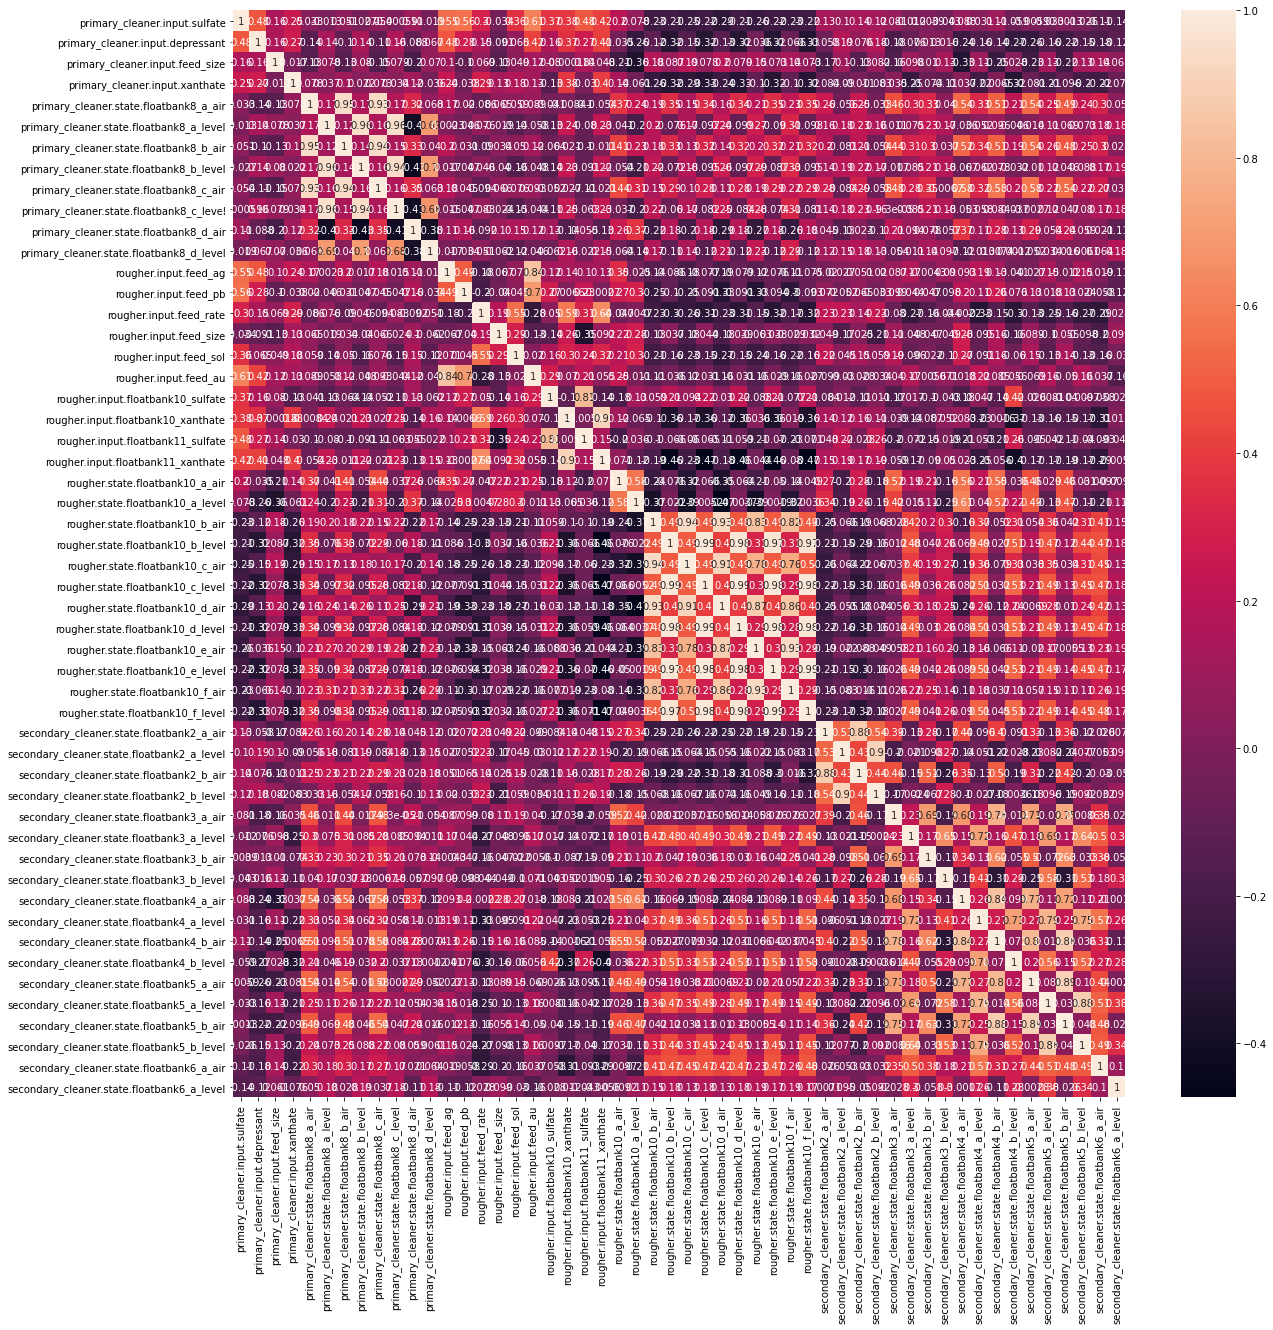

In [43]:
%%time
coor_matrix = features_train_final.corr()  # посмотрим на матрицу корреляции признаков выборки для флотации 
plt.figure(figsize=(20,20))
sns.heatmap(coor_matrix, annot=True);

In [44]:
# для применения линейной модели в тестовой выборке финальной очистки удалим признаки с корреляцией больше 0.8 
features_train_linear_final = features_train_final.drop([
        'primary_cleaner.state.floatbank8_a_air',
        'primary_cleaner.state.floatbank8_b_air',
        'primary_cleaner.state.floatbank8_a_level',
        'primary_cleaner.state.floatbank8_b_level',
        'secondary_cleaner.state.floatbank5_b_level',
        'secondary_cleaner.state.floatbank4_b_air',
        'rougher.state.floatbank10_c_level',
        'secondary_cleaner.state.floatbank5_b_air',
        'secondary_cleaner.state.floatbank2_b_air',
        'secondary_cleaner.state.floatbank2_b_level',
        'rougher.state.floatbank10_d_level',
        'rougher.state.floatbank10_e_level',
        'rougher.state.floatbank10_f_level',
        'rougher.input.floatbank11_sulfate',
        'rougher.input.floatbank11_xanthate',
        'rougher.input.feed_ag', 'rougher.state.floatbank10_b_air',
        'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_d_air',
        'rougher.state.floatbank10_e_air',], axis=1
)

# для применения линейной модели в тестовой выборке  удалим те же признаки 
features_test_linear_final = features_test_final.drop([
        'primary_cleaner.state.floatbank8_a_air',
        'primary_cleaner.state.floatbank8_b_air',
        'primary_cleaner.state.floatbank8_a_level',
        'primary_cleaner.state.floatbank8_b_level',
        'secondary_cleaner.state.floatbank5_b_level',
        'secondary_cleaner.state.floatbank4_b_air',
        'rougher.state.floatbank10_c_level',
        'secondary_cleaner.state.floatbank5_b_air',
        'secondary_cleaner.state.floatbank2_b_air',
        'secondary_cleaner.state.floatbank2_b_level',
        'rougher.state.floatbank10_d_level',
        'rougher.state.floatbank10_e_level',
        'rougher.state.floatbank10_f_level',
        'rougher.input.floatbank11_sulfate',
        'rougher.input.floatbank11_xanthate',
        'rougher.input.feed_ag', 'rougher.state.floatbank10_b_air',
        'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_d_air',
        'rougher.state.floatbank10_e_air',], axis=1
)

CPU times: user 822 ms, sys: 94.1 ms, total: 916 ms
Wall time: 951 ms


<AxesSubplot:>

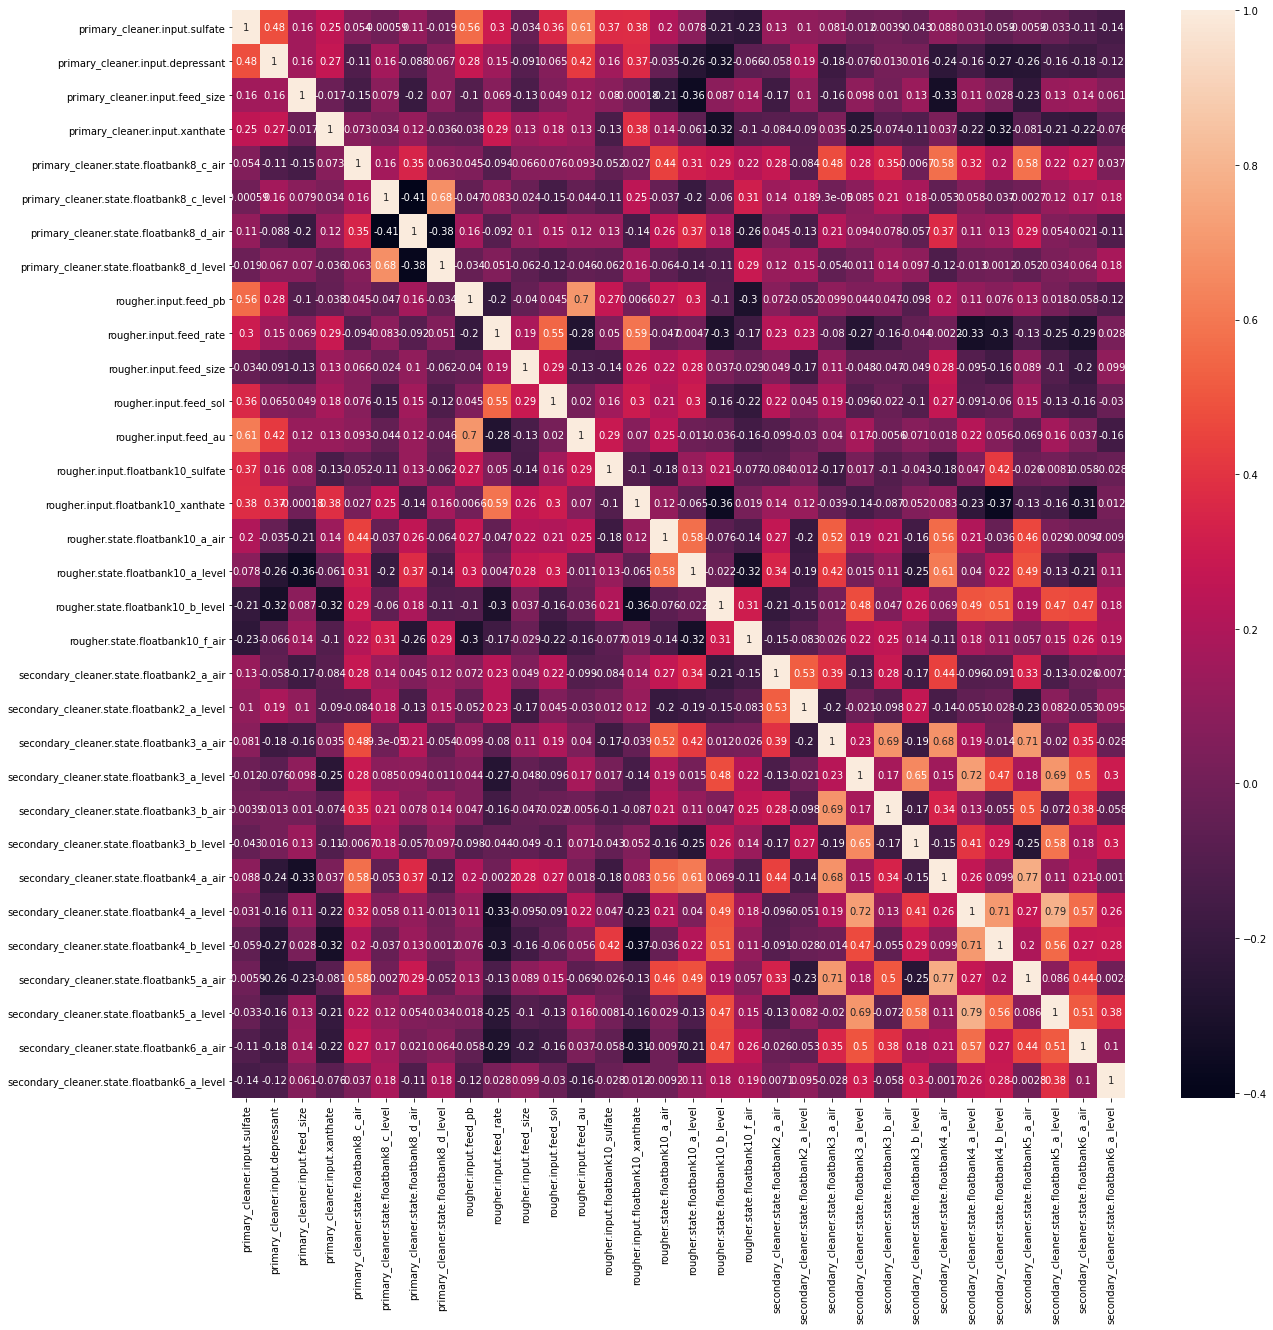

In [45]:
%%time
coor_matrix = features_train_linear_final.corr()  # посмотрим на матрицу корреляции признаков выборки для флотации 
plt.figure(figsize=(20,20))
sns.heatmap(coor_matrix, annot=True);

In [46]:
print(f'Размер тренировочной выборки для флотации: {features_train_rougher.shape}')
print(f'Размер тренировочной выборки для финальной очистки: {features_train_final.shape}')

print(f'Размер тестовой выборки для флотации: {features_test_rougher.shape}')
print(f'Размер тестовой выборки для финальной очистки: {features_test_final.shape}')

print(f'Размер тренировочной выборки линейной модели для флотации: {features_train_linear_rougher.shape}')
print(f'Размер тренировочной выборки линейной модели для финальной очистки: {features_train_linear_final.shape}')

print(f'Размер тестовой выборки линейной модели для флотации: {features_test_linear_rougher.shape}')
print(f'Размер тестовой выборки линейной модели для финальной очистки: {features_test_linear_final.shape}')

Размер тренировочной выборки для флотации: (14003, 22)
Размер тренировочной выборки для финальной очистки: (14003, 52)
Размер тестовой выборки для флотации: (5229, 22)
Размер тестовой выборки для финальной очистки: (5229, 52)
Размер тренировочной выборки линейной модели для флотации: (14003, 11)
Размер тренировочной выборки линейной модели для финальной очистки: (14003, 32)
Размер тестовой выборки линейной модели для флотации: (5229, 11)
Размер тестовой выборки линейной модели для финальной очистки: (5229, 32)


#### Для линейной модели масштабируем признаки.

In [47]:
def scaler(features_train, features_test):  # функция масштабирования признаков
    scaler = StandardScaler()
    scaler.fit(features_train) 
    features_train_scaled = scaler.transform(features_train)
    features_test_scaled = scaler.transform(features_test)
    return features_train_scaled, features_test_scaled

In [48]:
features_train_rougher_scaled, features_test_rougher_scaled = scaler(features_train_rougher, features_test_rougher)
features_train_final_scaled, features_test_final_scaled = scaler(features_train_final, features_test_final)

features_train_linear_rougher_scaled, features_test_linear_rougher_scaled = scaler(
    features_train_linear_rougher, features_test_linear_rougher
)
features_train_linear_final_scaled, features_test_linear_final_scaled = scaler(
    features_train_linear_final, features_test_linear_final
)

In [49]:
features_train_rougher_scaled = pd.DataFrame(features_train_rougher_scaled, columns=features_train_rougher.columns)
features_train_final_scaled = pd.DataFrame(features_train_final_scaled, columns=features_train_final.columns)

features_test_rougher_scaled = pd.DataFrame(features_test_rougher_scaled, columns=features_test_rougher.columns)
features_test_final_scaled = pd.DataFrame(features_test_final_scaled, columns=features_test_final.columns)

features_train_linear_rougher_scaled = pd.DataFrame(
    features_train_linear_rougher_scaled, columns=features_train_linear_rougher.columns
)
features_train_linear_final_scaled = pd.DataFrame(
    features_train_linear_final_scaled, columns=features_train_linear_final.columns
)

features_test_linear_rougher_scaled = pd.DataFrame(
    features_test_linear_rougher_scaled, columns=features_test_linear_rougher.columns
)
features_test_linear_final_scaled = pd.DataFrame(
    features_test_linear_final_scaled, columns=features_test_linear_final.columns
)

features_train_rougher_scaled.head()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,-1.337877,-1.137400,0.470853,-0.230303,0.079704,-0.739244,0.068666,0.128619,0.119474,0.153695,-0.740592,-0.366170,1.544127,0.526261,1.421830,0.420234,1.849436,0.265379,1.722133,0.176560,2.181588,0.234339
1,-1.305411,-1.154835,0.487904,-0.112917,-0.149335,-0.743230,0.063964,0.126559,0.161777,0.159245,-0.737172,-0.323609,1.531808,0.259228,1.412955,0.282920,1.856991,0.289615,1.693985,0.258215,2.086484,0.266666
2,-1.329283,-1.253103,0.534202,-0.097722,-0.101964,-0.804527,0.048540,0.304065,0.141648,0.316565,-0.740517,-0.323703,1.524071,0.258262,1.409178,0.280690,1.853769,0.289605,1.693737,0.274788,2.089898,0.259419
3,-1.368383,-1.365597,0.657020,-0.079245,0.091348,-0.933081,-0.040030,0.309438,0.081184,0.309966,-0.739955,-0.325044,1.528013,0.247548,1.410770,0.281482,1.843679,0.286424,1.703195,0.273143,2.089429,0.272493
4,-1.358972,-1.597327,0.636897,-0.193582,-0.454455,-1.172496,-0.245013,0.305408,-0.113039,0.308589,-0.740759,-0.320286,1.528828,0.265428,1.412385,0.279252,1.853340,0.290408,1.706510,0.293640,2.094720,0.261550


## Обучение модели

#### Напишем функцию для вычисления итоговой метрики sMAPE.

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

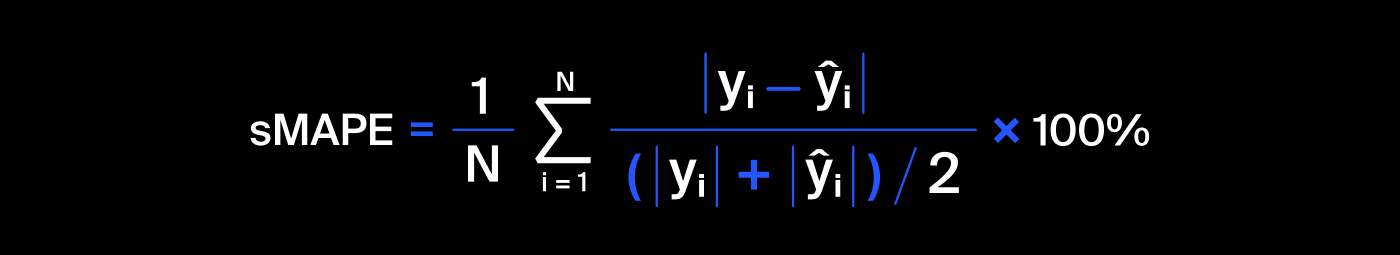

In [50]:
def smape(target,predict):
    smape = (abs(target-predict)*100/((abs(target)+abs(predict))*0.5)).mean()
    return smape

In [51]:
smape_scorer = make_scorer(smape)

In [52]:
def model_fitting(features_train, target_train, model):  # функция обучения и проверки модели кроссвалидацией
    model = model()
    scores = cross_val_score(model, features_train, target_train, scoring = smape_scorer, cv=5)
    smape = scores.mean() 
    return (smape)

In [53]:
# модель "Линейная регрессия"
smape_rougher_lin = model_fitting(features_train_linear_rougher_scaled, target_train_rougher, LinearRegression)
smape_final_lin = model_fitting(features_train_linear_final_scaled, target_train_final, LinearRegression)
smape_total = 0.25*smape_rougher_lin + 0.75*smape_final_lin # итоговая sMAPE
smape_total

11.50465960681185

In [54]:
%%time
# модель "Дерево решений"
best_depth = 0 
best_smape = 100
for depth in range(1, 8):
    model = DecisionTreeRegressor(random_state = 12345, max_depth = depth)
    smape_rougher = cross_val_score (
        model, features_train_rougher, target_train_rougher, scoring = smape_scorer, cv=5
    ).mean() 
    smape_final = cross_val_score (
        model, features_train_final, target_train_final, scoring = smape_scorer, cv=5
    ).mean()
    smape_total = 0.25*smape_rougher + 0.75*smape_final # итоговая sMAPE
    if smape_total < best_smape:
        best_depth = depth
        best_smape = smape_total
print (f'Итоговая sMAPE лучшей модели: {best_smape} при лучшей глубине:{best_depth}')

Итоговая sMAPE лучшей модели: 10.923253898945596 при лучшей глубине:3
CPU times: user 11.3 s, sys: 73 ms, total: 11.4 s
Wall time: 11.5 s


In [ ]:
%%time
# модель "Случайный лес"
best_smape = 100
best_est = 0
best_depth = 0
for est in range (3,20,3):
    for depth in range (1,6,3):
        model = RandomForestRegressor (random_state=12345, n_estimators=est, max_depth=depth)
        smape_scorer = make_scorer(smape)
        smape_rougher = cross_val_score (
            model, features_train_rougher, target_train_rougher, scoring=smape_scorer, cv=5
        ).mean()
        smape_final = cross_val_score (
            model, features_train_final, target_train_final, scoring=smape_scorer, cv=5
        ).mean()
        smape_total = 0.25*smape_rougher + 0.75*smape_final # итоговая sMAPE
        if smape_total < best_smape:
            best_smape = smape_total
            best_est = est
            best_depth = depth
print (f'Итоговая sMAPE лучшей модели: {best_smape}, количество деревьев: {best_est}, максимальная глубина: {best_depth}')

**Вывод.** Наилучшую метрику sMAPE показала последняя модель, "Случайный лес" c оценкой и параметрами:
- sMAPE = 10.439257747110673,
- количество деревьев - 18,
- максимальная глубина - 4.

## Тестирование модели

Проверим модель на тестовой выборке:

In [ ]:
%%time
# Обучаем конкретную модель с подобранными гиперпараметрами
model = RandomForestRegressor (random_state = 12345, n_estimators=18, max_depth =4)
model.fit(features_train_rougher, target_train_rougher)
predictions_rougher = model.predict(features_test_rougher) # предсказания модели
smape_rougher = smape(target_test_rougher, predictions_rougher)  
model.fit(features_train_final, target_train_final)
predictions_final = model.predict(features_test_final)
smape_final = smape(target_test_final, predictions_final) 
smape_total = 0.25*smape_rougher + 0.75*smape_final # итоговая sMAPE
print(f'Итоговая метрика sMAPE на тестовой выборке: {smape_total}')

Проверим модель на вменияемость с помощью модели DummyRegressor, предсказывающей среднее значение.

In [ ]:
model = DummyRegressor (strategy='mean')

model.fit(features_train_rougher, target_train_rougher)
predictions_rougher = model.predict(features_test_rougher)
smape_rougher = smape(target_test_rougher, predictions_rougher)
model.fit(features_train_final, target_train_final)
predictions_final = model.predict(features_test_final)
smape_final = smape(target_test_final, predictions_final)

smape_total = 0.25*smape_rougher + 0.75*smape_final

print (f'Итоговая метрика sMAPE для модели DummyRegressor: {smape_total}')

**Вывод.** Выбранная модель прошла проверку на тестовой выборке; а также проверку на адекватность, показав результат лучше, чем результат DummyRegressor.

## Общий вывод

В результате работы был проведен исследовательский анализ данных, обработка пропусков, удаление выбросов. Были проверены рассчеты эффективности обогащения золотой руды. Признаки подготовлены к обучению моделей.\
Для предсказания коэффициентов восстановления золота в черновом концентрате и финальном продукте была введена новая метрика качества sMAPE; были обучены и проверены кросс-валидацией модели: "Линейная регрессия", "Дерево решений", "Случайный лес". **Наилучшие результаты показала модель "Случайный лес" с оценкой sMAPE = 10.439257747110673 и параметрами: количество деревьев - 18, максимальная глубина - 4.\
Лучшая модель была протестирована на тестовой выборке. Итоговая метрика sMAPE модели на тестовой выборке: 8.998151380978776.**
Кроме того, полученная модель прошла проверку на адекватность, показав результат лучше, чем модель DummyRegressor.